In [ ]:
! pip install pyspark

In [ ]:
!pip install elephas

In [ ]:
# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

# Keras / Deep Learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam

# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator

In [ ]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [ ]:
features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
            "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
            "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
            "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
            "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
            "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
            "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
            "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [ ]:
dataset = spark.read.csv("/content/corrected", inferSchema=True, header=False)

In [ ]:
dataset = dataset.toDF(*features)

In [ ]:
from pyspark.sql.functions import regexp_replace
dataset = dataset.withColumn("label", regexp_replace("label", "\.", ""))

In [ ]:
print("Dataset sizes: {row} samples, {cols} features".format(row=dataset.count(), cols=len(dataset.columns)))

Dataset sizes: 311029 samples, 42 features


In [ ]:
def find_categorical_columns(df):
    categorical_columns = [col for (col, data_type) in df.dtypes if data_type == "string"]
    return categorical_columns

In [ ]:
# Identify categorical columns in the DataFrame
categorical_columns = find_categorical_columns(dataset)

# Print the result
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['protocol_type', 'service', 'flag', 'label']


In [ ]:
label = "label"

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
categorical_features = ["protocol_type", "service", "flag"]
'''indexers = [StringIndexer(inputCol=column, outputCol=column + "_num") for column in categorical_features]
indexers.append(StringIndexer(inputCol="label", outputCol="label_num"))
pipeline = Pipeline(stages=indexers)
dataset = pipeline.fit(dataset).transform(dataset)'''

'indexers = [StringIndexer(inputCol=column, outputCol=column + "_num") for column in categorical_features]\nindexers.append(StringIndexer(inputCol="label", outputCol="label_num"))\npipeline = Pipeline(stages=indexers)\ndataset = pipeline.fit(dataset).transform(dataset)'

In [ ]:
exclude_list = categorical_features + ["label"]
# print("Exclude list:")
print(exclude_list)

['protocol_type', 'service', 'flag', 'label']


In [ ]:
numerical_cols = [col for col in dataset.columns if col not in exclude_list]
print(numerical_cols)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [ ]:
'''df_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
dataset = df_assembler.transform(dataset)
dataset.printSchema()'''

'df_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")\ndataset = df_assembler.transform(dataset)\ndataset.printSchema()'

In [ ]:

# Check if "label_index" column already exists in the DataFrame
if "label_index" in dataset.columns:
    # Drop the existing "label_index" column
    dataset = dataset.drop("label_index")


In [ ]:
# Helper function to select features to scale given their skew
def select_features_to_scale(df=dataset, lower_skew=-2, upper_skew=2, dtypes='int32'):

    # Empty Selected Feature List for Output
    selected_features = []

    # Select Features to Scale based on Inputs ('in32' type, drop 'ID' columns or others, skew bounds)
    feature_list = list(df.toPandas().select_dtypes(include=[dtypes]))

    # Loop through 'feature_list' to select features based on Kurtosis / Skew
    for feature in feature_list:

        if df.toPandas()[feature].kurtosis() < -2 or df.toPandas()[feature].kurtosis() > 2:

            selected_features.append(feature)

    # Return feature list to scale
    return selected_features

In [ ]:
from pyspark.ml.feature import OneHotEncoder
# Pipeline Stages List
stages = []
# Loop for StringIndexer and OHE for Categorical Variables
for features in categorical_columns:
    # Index Categorical Features
    string_indexer = StringIndexer(inputCol=features, outputCol=features + "_index")

    # One Hot Encode Categorical Features
    encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()],
                            outputCols=[features + "_class_vec"])

    # Append Pipeline Stages
    stages += [string_indexer, encoder]

# Index Label Feature (moved outside the loop)
label_str_index = StringIndexer(inputCol=label, outputCol="label_num")

# Scale Feature: Select the Features to Scale using helper 'select_features_to_scale' function above and Standardize
'''unscaled_features = select_features_to_scale(df=dataset, lower_skew=-2, upper_skew=2)

unscaled_assembler = VectorAssembler(inputCols=unscaled_features, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features")

stages += [unscaled_assembler, scaler]

# Create list of Numeric Features that Are Not Being Scaled
num_unscaled_diff_list = list(set(numerical_cols) - set(unscaled_features))'''

# Assemble or Concat the Categorical Features and Numeric Features
assembler_inputs = [feature + "_class_vec" for feature in categorical_columns] + numerical_cols

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="assembled_inputs")

stages += [label_str_index, assembler]

# Assemble Final Training Data of Scaled, Numeric, and Categorical Engineered Features
assembler_final = VectorAssembler(inputCols=["assembled_inputs"], outputCol="features")

stages += [assembler_final]

In [ ]:
stages

[StringIndexer_9c30ae28496a,
 OneHotEncoder_c050ed9189c2,
 StringIndexer_0e6255e96fa3,
 OneHotEncoder_1656a3adf74d,
 StringIndexer_5212ba6cf67c,
 OneHotEncoder_0af9fc7ef557,
 StringIndexer_89a09ef52893,
 OneHotEncoder_8b95fdc71c81,
 StringIndexer_6144289a73dd,
 VectorAssembler_34e11785498b,
 VectorAssembler_a905308438e5]

In [ ]:
# Set Pipeline
pipeline = Pipeline(stages=stages)

# Fit Pipeline to Data
pipeline_model = pipeline.fit(dataset)

# Transform Data using Fitted Pipeline
df_transform = pipeline_model.transform(dataset)

In [ ]:
df_transform.show()

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------+-------------------+-----------------------+-------------+-----------------+----------+--------------+-----------+---------------+---------+--------------------+--------------------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|

In [ ]:
# Preview Newly Transformed Data
df_transform.limit(5).toPandas()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,protocol_type_class_vec,service_index,service_class_vec,flag_index,flag_class_vec,label_index,label_class_vec,label_num,assembled_inputs,features
0,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,udp,private,SF,105,146,0,0,0,0,...,"(0.0, 0.0)",1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Data Structure Type is a PySpark Dataframe
type(df_transform)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Select only 'features' and 'label_index' for Final Dataframe
df_transform_fin = df_transform.select('features','label_num')

In [ ]:
# Shuffle Data
df_transform_fin = df_transform_fin.orderBy(rand())

In [ ]:
df_transform_fin1 = dataset[numerical_cols].toPandas()

In [ ]:
label_num_column = dataset.select('label').toPandas()
df_transform_fin1['label_num'] = label_num_column['label']
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_transform_fin1['label_num_encoded'] = label_encoder.fit_transform(df_transform_fin1['label_num'])

In [ ]:
df_transform_fin1.drop('label_num', axis=1, inplace=True)
df_transform_fin1

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label_num_encoded
0,0,105,146,0,0,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,16
1,0,105,146,0,0,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,16
2,0,105,146,0,0,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,16
3,0,105,146,0,0,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,28
4,0,105,146,0,0,0,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311024,0,105,147,0,0,0,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,16
311025,0,105,147,0,0,0,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,16
311026,0,105,147,0,0,0,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,16
311027,0,105,147,0,0,0,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,16


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA
pca = PCA(k=20, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_transform_fin)
dataset_pca = pca_model.transform(df_transform_fin)

In [ ]:
dataset_pca.count()

311029

In [ ]:
# Select the PCA features and label for the final dataset
dataset_pca = dataset_pca.select(["pca_features", "label_num"])

In [ ]:
# SHAP Explanation
# Convert Spark DataFrame to Pandas DataFrame
dataset_pca1 = dataset_pca.toPandas()

In [ ]:
import pandas as pd
# Split the 'features_dense' column into multiple columns
df_features_split = pd.DataFrame(dataset_pca1['pca_features'].tolist(), columns=['feature_' + str(i) for i in range(len(dataset_pca1['pca_features'].iloc[0]))])

In [ ]:
# Concatenate the new columns with the original DataFrame
dataset_pca1 = pd.concat([dataset_pca1, df_features_split], axis=1)

# Drop the original 'features_dense' column
dataset_pca1 = dataset_pca1.drop('pca_features', axis=1)

In [ ]:
# Split Data into Train / Test Sets
train_data, test_data = df_transform_fin.randomSplit([.8, .2],seed=1234)

In [ ]:
# Split Data into Train / Test Sets
train_data2, test_data2 = dataset_pca.randomSplit([.8, .2],seed=1234)

In [ ]:
from sklearn.model_selection import train_test_split
X = df_transform_fin1.drop('label_num_encoded', axis=1)  # Features (all columns except the target)
y = df_transform_fin1['label_num_encoded']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X1 = dataset_pca1.drop('label_num', axis=1)  # Features (all columns except the target)
y1 = dataset_pca1['label_num']  # Target variable
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [ ]:
# Number of Classes
nb_classes1 = train_data.select("label_num").distinct().count()
# Number of Inputs or Input Dimensions
input_dim1 = len(train_data.select("features").first()[0])
# Number of Classes
nb_classes = y_train.nunique()
# Number of Inputs or Input Dimensions
input_dim = X_train.shape[1]

In [ ]:
# Define Keras model
keras_model = Sequential()
keras_model.add(Dense(512, input_shape=(X_train.shape[1],), activity_regularizer=regularizers.l2(0.0001)))
keras_model.add(Activation('relu'))
keras_model.add(Dense(512, activation='relu'))
keras_model.add(Dense(256, activity_regularizer=regularizers.l2(0.0001)))
keras_model.add(Activation('relu'))
keras_model.add(Dense(38, activation='softmax'))  # Adjust the number of classes
optimizer = Adam(learning_rate=0.001)  # Experiment with different learning rates
keras_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               19968     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 38)                9766      
                                                                 
Total params: 423718 (1.62 MB)
Trainable params: 423718 

In [ ]:
# Set and Serialize Optimizer
optimizer_conf = optimizers.Adam(lr=0.01)
opt_conf = optimizers.serialize(optimizer_conf)

# Initialize SparkML Estimator and Get Settings
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")
estimator.setLabelCol("label_num")
estimator.set_keras_model_config(keras_model.to_json())
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(1)
estimator.set_epochs(25)
estimator.set_batch_size(64)
estimator.set_verbosity(1)
estimator.set_validation_split(0.10)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss("binary_crossentropy")
estimator.set_metrics(['acc'])

ElephasEstimator_ff7f8cfa8fa7

In [ ]:
# Create Deep Learning Pipeline
dl_pipeline = Pipeline(stages=[estimator])

In [ ]:
def dl_pipeline_fit_score_results(dl_pipeline=dl_pipeline,
                                  train_data=train_data,
                                  test_data=test_data,
                                  label='label_num'):

    fit_dl_pipeline = dl_pipeline.fit(train_data)
    pred_train = fit_dl_pipeline.transform(train_data)
    pred_test = fit_dl_pipeline.transform(test_data)

    pnl_train = pred_train.select(label, "prediction")
    pnl_test = pred_test.select(label, "prediction")

    pred_and_label_train = pnl_train.rdd.map(lambda row: (row[label], row['prediction']))
    pred_and_label_test = pnl_test.rdd.map(lambda row: (row[label], row['prediction']))

    metrics_train = MulticlassMetrics(pred_and_label_train)
    metrics_test = MulticlassMetrics(pred_and_label_test)

    print("Training Data Accuracy: {}".format(round(metrics_train.precision(),4)))
    print("Training Data Confusion Matrix")
    display(pnl_train.crosstab('label_num', 'prediction').toPandas())

    print("\nTest Data Accuracy: {}".format(round(metrics_test.precision(),4)))
    print("Test Data Confusion Matrix")
    display(pnl_test.crosstab('label_num', 'prediction').toPandas())

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train, num_classes=38)
# Train the model
history = keras_model.fit(X_train, y_train_categorical, epochs=30, batch_size=32)

Epoch 1/30
7776/7776 [==============================] - 51s 6ms/step - loss: 63445.4609 - accuracy: 0.8872
Epoch 2/30
7776/7776 [==============================] - 47s 6ms/step - loss: 176284.5000 - accuracy: 0.8948
Epoch 3/30
7776/7776 [==============================] - 47s 6ms/step - loss: 172282.5469 - accuracy: 0.9026
Epoch 4/30
7776/7776 [==============================] - 47s 6ms/step - loss: 124216.4609 - accuracy: 0.9171
Epoch 5/30
7776/7776 [==============================] - 46s 6ms/step - loss: 162597.3125 - accuracy: 0.8950
Epoch 6/30
7776/7776 [==============================] - 46s 6ms/step - loss: 63230.8711 - accuracy: 0.8467
Epoch 7/30
7776/7776 [==============================] - 46s 6ms/step - loss: 323505.8750 - accuracy: 0.8907
Epoch 8/30
7776/7776 [==============================] - 70s 9ms/step - loss: 159202.3125 - accuracy: 0.9052
Epoch 9/30
7776/7776 [==============================] - 47s 6ms/step - loss: 99440.3438 - accuracy: 0.8995
Epoch 10/30
7776/7776 [========

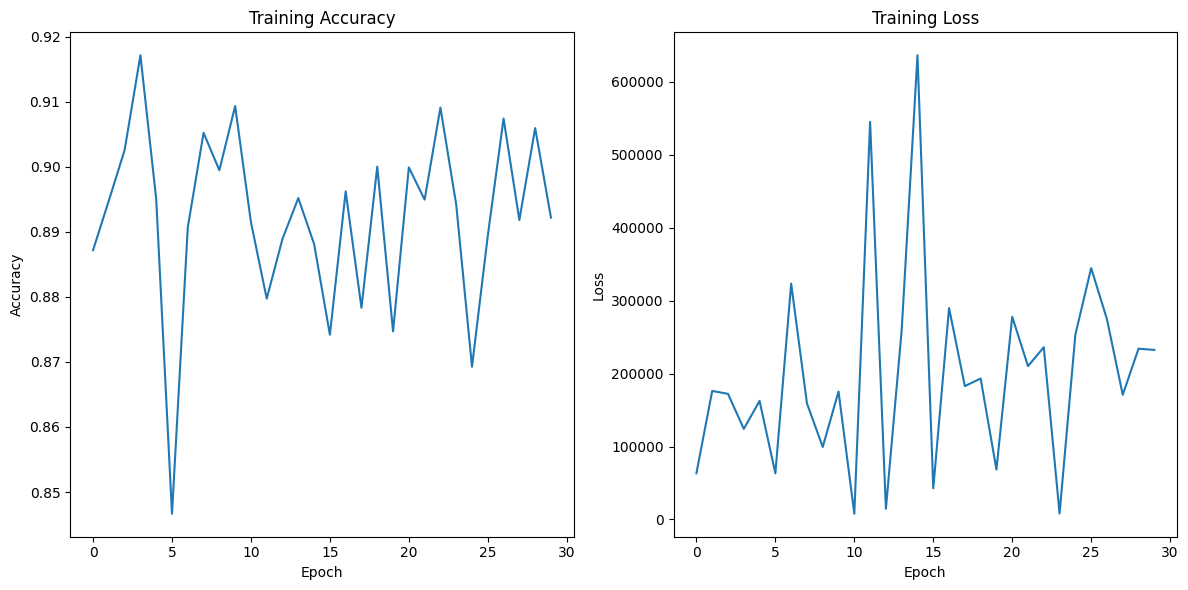

In [ ]:
import matplotlib.pyplot as plt
# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
accuracy = keras_model.evaluate(X_train, y_train_categorical)[1]
print("Training Accuracy: {:.2f}%".format(accuracy * 100))

7776/7776 [==============================] - 17s 2ms/step - loss: 247926.8594 - accuracy: 0.9117
Training Accuracy: 91.17%


In [ ]:
print(set(y_test))

{0, 1, 2, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 32, 33, 35, 36, 37}


In [ ]:
y_test_categorical = to_categorical(y_test, num_classes=38)

In [ ]:
# Evaluate the model on the test set
accuracy = keras_model.evaluate(X_test, y_test_categorical)[1]
print("Testing Accuracy: {:.2f}%".format(accuracy * 100))

1944/1944 [==============================] - 10s 5ms/step - loss: 4754.1313 - accuracy: 0.9123
Testing Accuracy: 91.23%


1944/1944 [==============================] - 4s 2ms/step


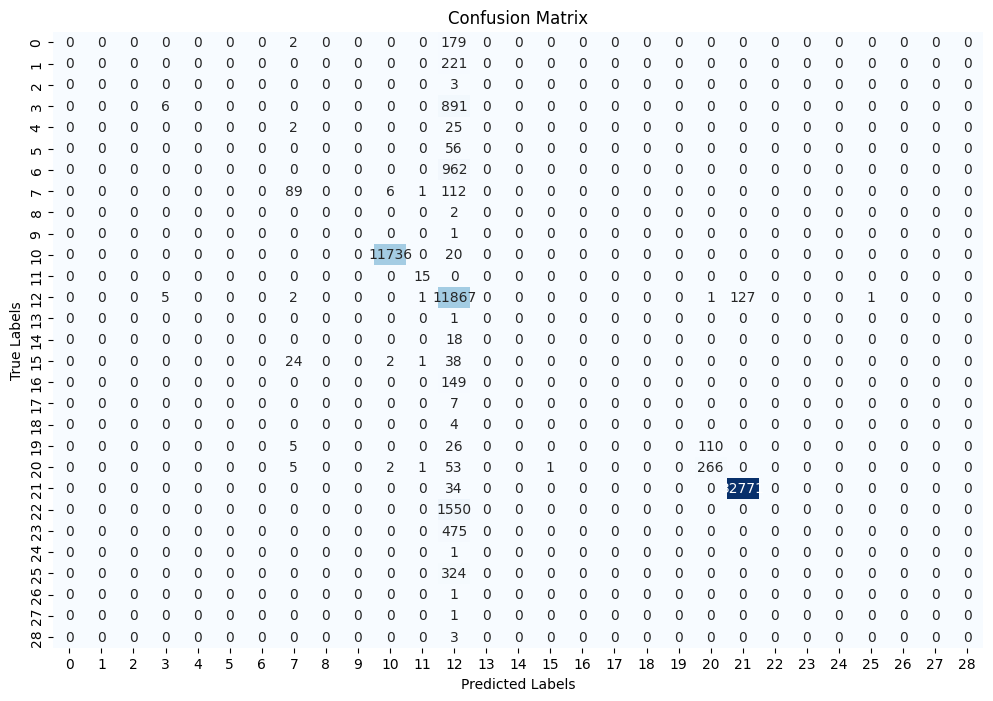

In [ ]:
# Assuming you have obtained predictions
y_pred = keras_model.predict(X_test)
import numpy as np

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
! pip install shap

In [ ]:
import shap
# Explain the model predictions using Kernel SHAP
explainer = shap.KernelExplainer(keras_model.predict, shap.sample(X_train, 100))

4/4 [==============================] - 0s 3ms/step


In [ ]:
shap_values = explainer.shap_values(shap.sample(X_train, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

6557/6557 [==============================] - 14s 2ms/step


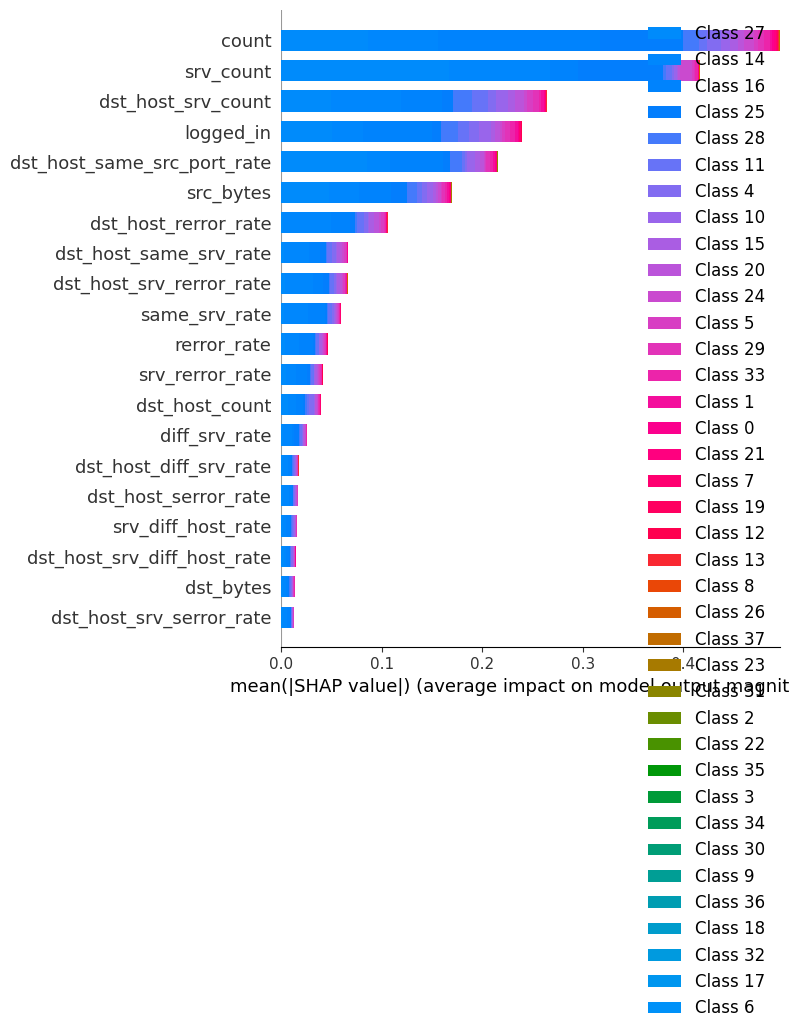

In [ ]:
# Summarize the feature importance
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

In [ ]:
# Number of Classes
nb_classes = y_train1.nunique()
# Number of Inputs or Input Dimensions
input_dim = X_train1.shape[1]

In [ ]:
# Define Keras model
keras_model = Sequential()
keras_model.add(Dense(512, input_shape=(X_train1.shape[1],), activity_regularizer=regularizers.l2(0.0001)))
keras_model.add(Activation('relu'))
keras_model.add(Dense(512, activation='relu'))
keras_model.add(Dense(256, activity_regularizer=regularizers.l2(0.0001)))
keras_model.add(Activation('relu'))
keras_model.add(Dense(38, activation='softmax'))  # Adjust the number of classes
optimizer = Adam(learning_rate=0.001)  # Experiment with different learning rates
keras_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               10752     
                                                                 
 activation_2 (Activation)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 38)                9766      
                                                                 
Total params: 414502 (1.58 MB)
Trainable params: 41450

In [ ]:
# Set and Serialize Optimizer
optimizer_conf = optimizers.Adam(lr=0.01)
opt_conf = optimizers.serialize(optimizer_conf)

# Initialize SparkML Estimator and Get Settings
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")
estimator.setLabelCol("label_num")
estimator.set_keras_model_config(keras_model.to_json())
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(1)
estimator.set_epochs(25)
estimator.set_batch_size(64)
estimator.set_verbosity(1)
estimator.set_validation_split(0.10)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss("binary_crossentropy")
estimator.set_metrics(['acc'])

ElephasEstimator_baca149c1a73

In [ ]:
# Create Deep Learning Pipeline
dl_pipeline = Pipeline(stages=[estimator])

In [ ]:
def dl_pipeline_fit_score_results(dl_pipeline=dl_pipeline,
                                  train_data=train_data,
                                  test_data=test_data,
                                  label='label_index'):

    fit_dl_pipeline = dl_pipeline.fit(train_data)
    pred_train = fit_dl_pipeline.transform(train_data)
    pred_test = fit_dl_pipeline.transform(test_data)

    pnl_train = pred_train.select(label, "prediction")
    pnl_test = pred_test.select(label, "prediction")

    pred_and_label_train = pnl_train.rdd.map(lambda row: (row[label], row['prediction']))
    pred_and_label_test = pnl_test.rdd.map(lambda row: (row[label], row['prediction']))

    metrics_train = MulticlassMetrics(pred_and_label_train)
    metrics_test = MulticlassMetrics(pred_and_label_test)

    print("Training Data Accuracy: {}".format(round(metrics_train.precision(),4)))
    print("Training Data Confusion Matrix")
    display(pnl_train.crosstab('label_index', 'prediction').toPandas())

    print("\nTest Data Accuracy: {}".format(round(metrics_test.precision(),4)))
    print("Test Data Confusion Matrix")
    display(pnl_test.crosstab('label_index', 'prediction').toPandas())

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_categorical1 = to_categorical(y_train1, num_classes=38)
# Train the model
history = keras_model.fit(X_train1, y_train_categorical1, epochs=30, batch_size=32)

Epoch 1/30
7776/7776 [==============================] - 47s 6ms/step - loss: 51891.2969 - accuracy: 0.8926
Epoch 2/30
7776/7776 [==============================] - 49s 6ms/step - loss: 161996.3438 - accuracy: 0.9067
Epoch 3/30
7776/7776 [==============================] - 46s 6ms/step - loss: 211774.8438 - accuracy: 0.8440
Epoch 4/30
7776/7776 [==============================] - 46s 6ms/step - loss: 155256.5000 - accuracy: 0.8877
Epoch 5/30
7776/7776 [==============================] - 46s 6ms/step - loss: 188200.1250 - accuracy: 0.8597
Epoch 6/30
7776/7776 [==============================] - 46s 6ms/step - loss: 10944.0225 - accuracy: 0.9652
Epoch 7/30
7776/7776 [==============================] - 45s 6ms/step - loss: 222963.4062 - accuracy: 0.7218
Epoch 8/30
7776/7776 [==============================] - 46s 6ms/step - loss: 315776.4062 - accuracy: 0.9204
Epoch 9/30
7776/7776 [==============================] - 46s 6ms/step - loss: 461366.8750 - accuracy: 0.8949
Epoch 10/30
7776/7776 [=======

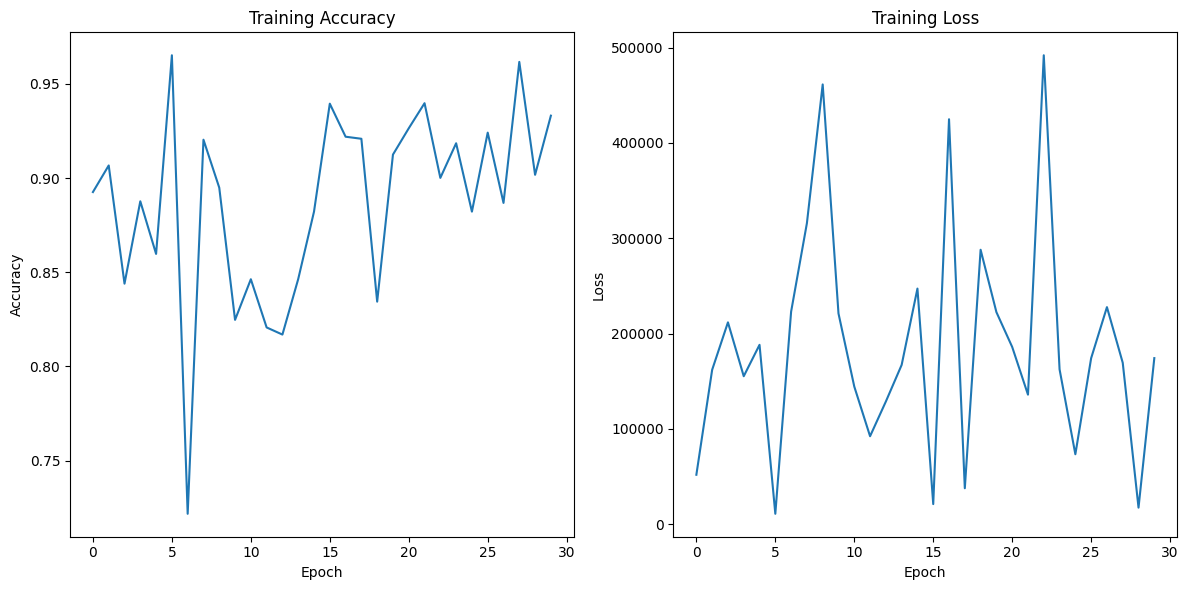

In [ ]:
import matplotlib.pyplot as plt
# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
accuracy = keras_model.evaluate(X_train1, y_train_categorical1)[1]
print("Training Accuracy: {:.2f}%".format(accuracy * 100))

7776/7776 [==============================] - 16s 2ms/step - loss: 2627.5051 - accuracy: 0.9870
Training Accuracy: 98.70%


In [ ]:
print(set(y_test1))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 32.0, 35.0}


In [ ]:
y_test_categorical1 = to_categorical(y_test1, num_classes=38)

In [ ]:
# Evaluate the model on the test set
accuracy = keras_model.evaluate(X_test1, y_test_categorical1)[1]
print("Testing Accuracy: {:.2f}%".format(accuracy * 100))

1944/1944 [==============================] - 4s 2ms/step - loss: 103.7936 - accuracy: 0.9869
Testing Accuracy: 98.69%


1944/1944 [==============================] - 4s 2ms/step


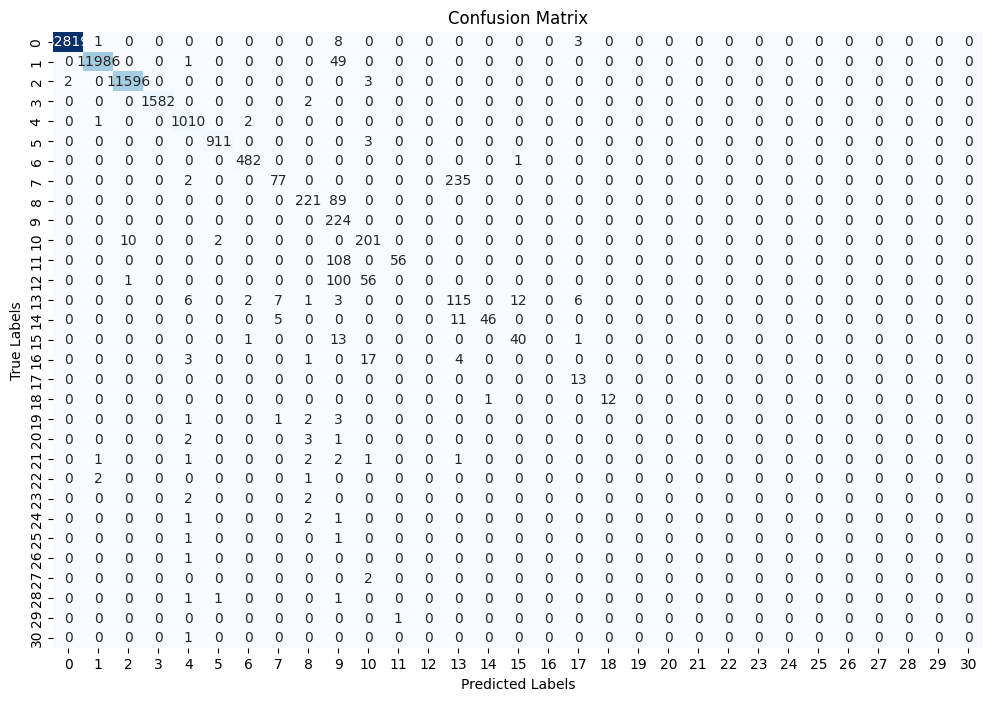

In [ ]:
# Assuming you have obtained predictions
y_pred1 = keras_model.predict(X_test1)
import numpy as np

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_true_classes1 = np.argmax(y_test_categorical1, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true_classes1, y_pred_classes1)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import shap
# Explain the model predictions using Kernel SHAP
explainer = shap.KernelExplainer(keras_model.predict, shap.sample(X_train1, 100))

4/4 [==============================] - 0s 3ms/step


In [ ]:
shap_values = explainer.shap_values(shap.sample(X_train1, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

6525/6525 [==============================] - 12s 2ms/step


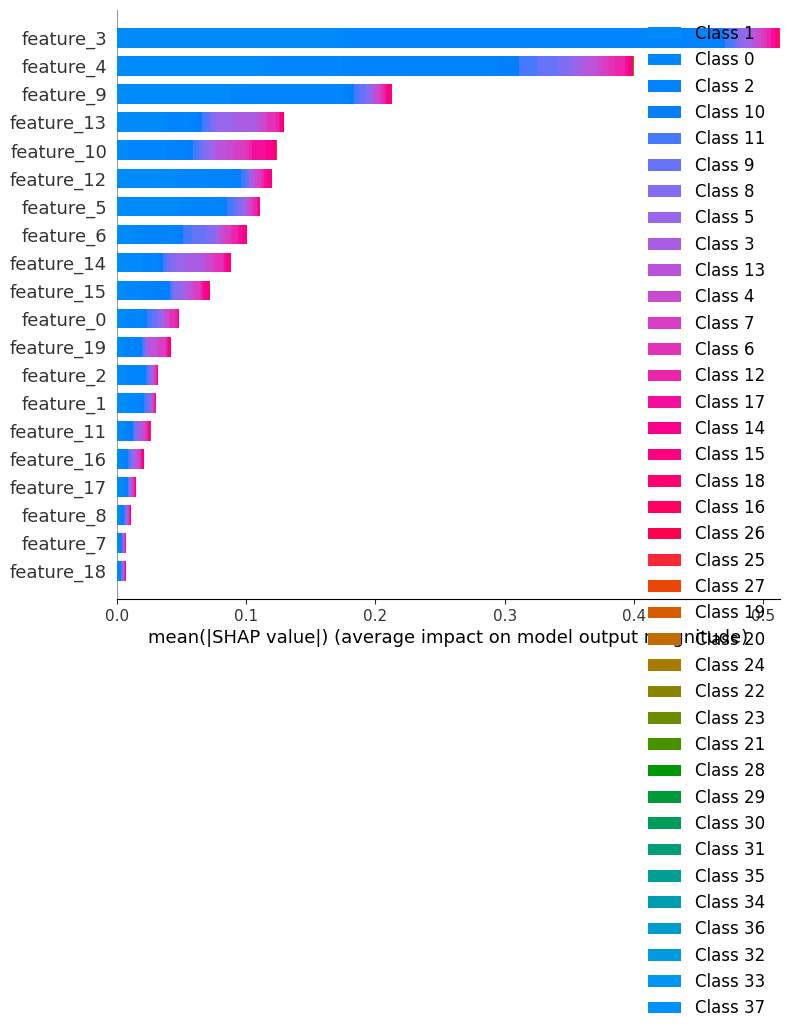

In [ ]:
# Summarize the feature importance
shap.summary_plot(shap_values, X_train1, feature_names=X_train1.columns)

In [ ]:
# Select only 'features' and 'label_index' for Final Dataframe
df_transform_fin2 = df_transform.select('features','label_num')

In [ ]:
# Preview Newly Transformed Data
df_transform_fin2.limit(5).toPandas()

,features,label_num
0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0
4,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0


In [ ]:
# Split Data into Train / Test Sets
train_data, test_data = df_transform_fin2.randomSplit([.8, .2],seed=1234)

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
# Counting occurrences of each unique value in the output column
label_counts = test_data.groupBy("label_num").count().orderBy("label_num")
label_counts.show()

+---------+-----+
|label_num|count|
+---------+-----+
|      0.0|32666|
|      1.0|12170|
|      2.0|11409|
|      3.0| 1539|
|      4.0|  982|
|      5.0|  867|
|      6.0|  468|
|      7.0|  318|
|      8.0|  294|
|      9.0|  204|
|     10.0|  213|
|     11.0|  175|
|     12.0|  147|
|     13.0|  158|
|     14.0|   58|
|     15.0|   55|
|     16.0|   35|
|     17.0|   16|
|     18.0|   18|
|     19.0|    8|
+---------+-----+
only showing top 20 rows



In [ ]:
# Set the threshold for minimum occurrences
threshold = 90

# Filter the label counts DataFrame to keep only the rows with counts greater than or equal to the threshold
filtered_label_counts = label_counts.filter(label_counts["count"] >= threshold)

# Extract the label numbers that meet the threshold
selected_labels = filtered_label_counts.select("label_num").rdd.flatMap(lambda x: x).collect()

# Filter the training set to keep only the rows with labels that meet the threshold
filtered_train_set = test_data.filter(test_data["label_num"].isin(selected_labels))

# Display the new label counts after filtering
new_label_counts = filtered_train_set.groupBy("label_num").count().orderBy("count", ascending=False)
print("New Label Counts in the Training Set:")
new_label_counts.show(new_label_counts.count(), False)

# Split features and labels in the filtered training set
filtered_train_features = filtered_train_set.select("features")
filtered_train_labels = filtered_train_set.select("label_num")

New Label Counts in the Training Set:
+---------+-----+
|label_num|count|
+---------+-----+
|0.0      |32666|
|1.0      |12170|
|2.0      |11409|
|3.0      |1539 |
|4.0      |982  |
|5.0      |867  |
|6.0      |468  |
|7.0      |318  |
|8.0      |294  |
|10.0     |213  |
|9.0      |204  |
|11.0     |175  |
|13.0     |158  |
|12.0     |147  |
+---------+-----+



In [ ]:
# Separate features and labels
X_train = filtered_train_features.toPandas()
# Assuming y_train is your Pandas DataFrame
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
y_train = filtered_train_labels.toPandas()

In [ ]:
len(X_train)

61610

In [ ]:
len(y_train)

61610

In [ ]:
# Separate features and labels
X_train = X_train["features"].tolist()
y_train = y_train["label_num"].tolist()

In [ ]:
# Instantiate ADASYN with optional parameters
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
# Apply ADASYN to the training data
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [ ]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
import pandas as pd
# Combine resampled features and labels into a new DataFrame
resampled_features = [DenseVector(x) for x in X_resampled]
train_set_resampled = spark.createDataFrame(pd.DataFrame(data={"features_dense": resampled_features, "label_num": y_resampled}))
train_set_resampled = train_set_resampled.withColumn("label_num", col("label_num").cast("integer"))

In [ ]:
# Counting occurrences of each unique value in the output column
label_counts = train_set_resampled.groupBy("label_num").count().orderBy("label_num")
label_counts.show()

+---------+-----+
|label_num|count|
+---------+-----+
|        0|32666|
|        1|12170|
|        2|11409|
|        3| 1539|
|        4|  982|
|        5|  867|
|        6|  468|
|        7|  318|
|        8|  294|
|        9|  204|
|       10|  213|
|       11|  175|
|       12|32725|
|       13|  158|
+---------+-----+



In [ ]:
train_set_resampled = train_set_resampled.toPandas()

In [ ]:
train_set_resampled

,features_dense,label_num
0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...
94183,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12
94184,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12
94185,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12
94186,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12


In [ ]:
import pandas as pd
# Split the 'features_dense' column into multiple columns
df_features_split = pd.DataFrame(train_set_resampled['features_dense'].tolist(), columns=['feature_' + str(i) for i in range(len(train_set_resampled['features_dense'].iloc[0]))])
df_features_split

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,251.0,0.98,0.01,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,9.0,0.04,0.06,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94183,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0
94184,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0
94185,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0
94186,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_features_split = df_features_split.iloc[:, -41:]

In [ ]:
# Define the column names
column_names = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
                'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
                'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
                'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_num',
                'service_num', 'flag_num']

# Assign the column names to the DataFrame
df_features_split.columns = column_names

In [ ]:
# Concatenate the new columns with the original DataFrame
dataset_adasyn = pd.concat([train_set_resampled, df_features_split], axis=1)

# Drop the original 'features_dense' column
dataset_adasyn = dataset_adasyn.drop('features_dense', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X2 = dataset_adasyn.drop('label_num', axis=1)  # Features (all columns except the target)
y2 = dataset_adasyn['label_num']  # Target variable
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [ ]:
# Number of Classes
nb_classes = y_train2.nunique()
# Number of Inputs or Input Dimensions
input_dim = X_train2.shape[1]
# Define Keras model
keras_model = Sequential()
keras_model.add(Dense(512, input_shape=(X_train2.shape[1],), activity_regularizer=regularizers.l2(0.0001)))
keras_model.add(Activation('relu'))
keras_model.add(Dense(512, activation='relu'))
keras_model.add(Dense(256, activity_regularizer=regularizers.l2(0.0001)))
keras_model.add(Activation('relu'))
keras_model.add(Dense(38, activation='softmax'))  # Adjust the number of classes
optimizer = Adam(learning_rate=0.001)  # Experiment with different learning rates
keras_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Set and Serialize Optimizer
optimizer_conf = optimizers.Adam(lr=0.01)
opt_conf = optimizers.serialize(optimizer_conf)

# Initialize SparkML Estimator and Get Settings
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")
estimator.setLabelCol("label_index")
estimator.set_keras_model_config(keras_model.to_json())
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(1)
estimator.set_epochs(25)
estimator.set_batch_size(64)
estimator.set_verbosity(1)
estimator.set_validation_split(0.10)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss("binary_crossentropy")
estimator.set_metrics(['acc'])

ElephasEstimator_0260a3383c62

In [ ]:
def dl_pipeline_fit_score_results(dl_pipeline=dl_pipeline,
                                  train_data=train_data,
                                  test_data=test_data,
                                  label='label_index'):

    fit_dl_pipeline = dl_pipeline.fit(train_data)
    pred_train = fit_dl_pipeline.transform(train_data)
    pred_test = fit_dl_pipeline.transform(test_data)

    pnl_train = pred_train.select(label, "prediction")
    pnl_test = pred_test.select(label, "prediction")

    pred_and_label_train = pnl_train.rdd.map(lambda row: (row[label], row['prediction']))
    pred_and_label_test = pnl_test.rdd.map(lambda row: (row[label], row['prediction']))

    metrics_train = MulticlassMetrics(pred_and_label_train)
    metrics_test = MulticlassMetrics(pred_and_label_test)

    print("Training Data Accuracy: {}".format(round(metrics_train.precision(),4)))
    print("Training Data Confusion Matrix")
    display(pnl_train.crosstab('label_index', 'prediction').toPandas())

    print("\nTest Data Accuracy: {}".format(round(metrics_test.precision(),4)))
    print("Test Data Confusion Matrix")
    display(pnl_test.crosstab('label_index', 'prediction').toPandas())

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_categorical2 = to_categorical(y_train2, num_classes=38)
# Train the model
history = keras_model.fit(X_train2, y_train_categorical2, epochs=30, batch_size=32)

Epoch 1/30
2355/2355 [==============================] - 14s 6ms/step - loss: 1704.0637 - accuracy: 0.3628
Epoch 2/30
2355/2355 [==============================] - 14s 6ms/step - loss: 652.9986 - accuracy: 0.3570
Epoch 3/30
2355/2355 [==============================] - 14s 6ms/step - loss: 401.7154 - accuracy: 0.3463
Epoch 4/30
2355/2355 [==============================] - 14s 6ms/step - loss: 2114.8230 - accuracy: 0.3469
Epoch 5/30
2355/2355 [==============================] - 14s 6ms/step - loss: 136.8960 - accuracy: 0.3468
Epoch 6/30
2355/2355 [==============================] - 14s 6ms/step - loss: 761.0740 - accuracy: 0.3469
Epoch 7/30
2355/2355 [==============================] - 14s 6ms/step - loss: 1031.9181 - accuracy: 0.3467
Epoch 8/30
2355/2355 [==============================] - 14s 6ms/step - loss: 466.6803 - accuracy: 0.3463
Epoch 9/30
2355/2355 [==============================] - 14s 6ms/step - loss: 1599.4757 - accuracy: 0.3461
Epoch 10/30
2355/2355 [============================

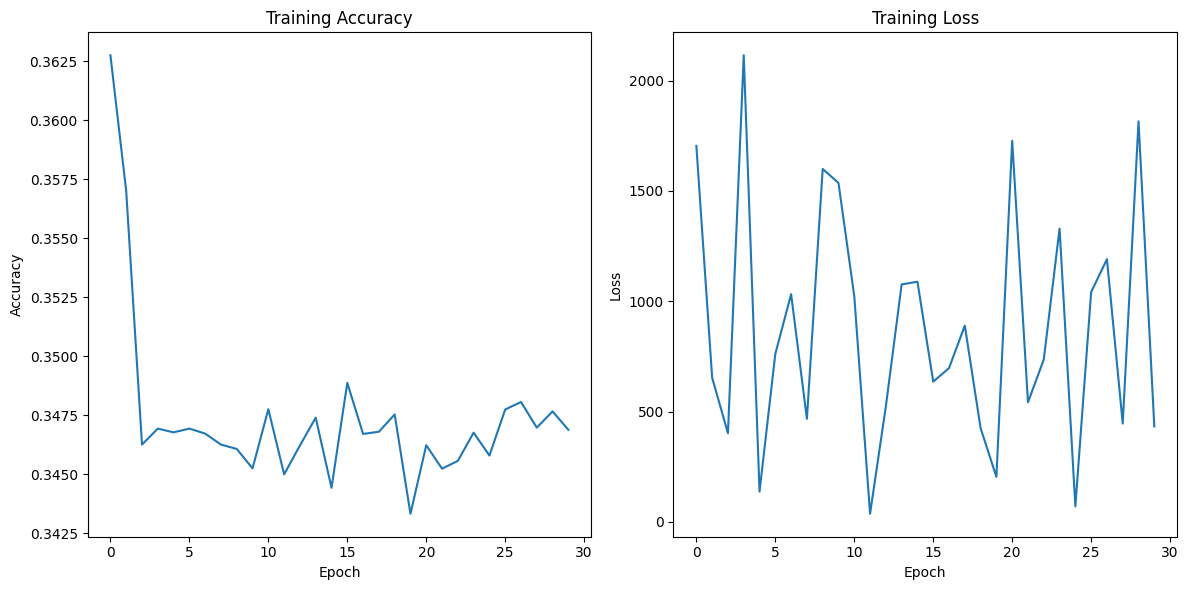

In [ ]:
import matplotlib.pyplot as plt
# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
accuracy2 = keras_model.evaluate(X_train2, y_train_categorical2)[1]
print("Training Accuracy: {:.2f}%".format(accuracy2 * 100))

2355/2355 [==============================] - 5s 2ms/step - loss: 2372.4873 - accuracy: 0.3467
Training Accuracy: 34.67%


In [ ]:
y_test_categorical2 = to_categorical(y_test2, num_classes=38)

In [ ]:
# Evaluate the model on the test set
accuracy2 = keras_model.evaluate(X_test2, y_test_categorical2)[1]
print("Testing Accuracy: {:.2f}%".format(accuracy2 * 100))

589/589 [==============================] - 2s 3ms/step - loss: 232.0016 - accuracy: 0.3472
Testing Accuracy: 34.72%


589/589 [==============================] - 1s 2ms/step


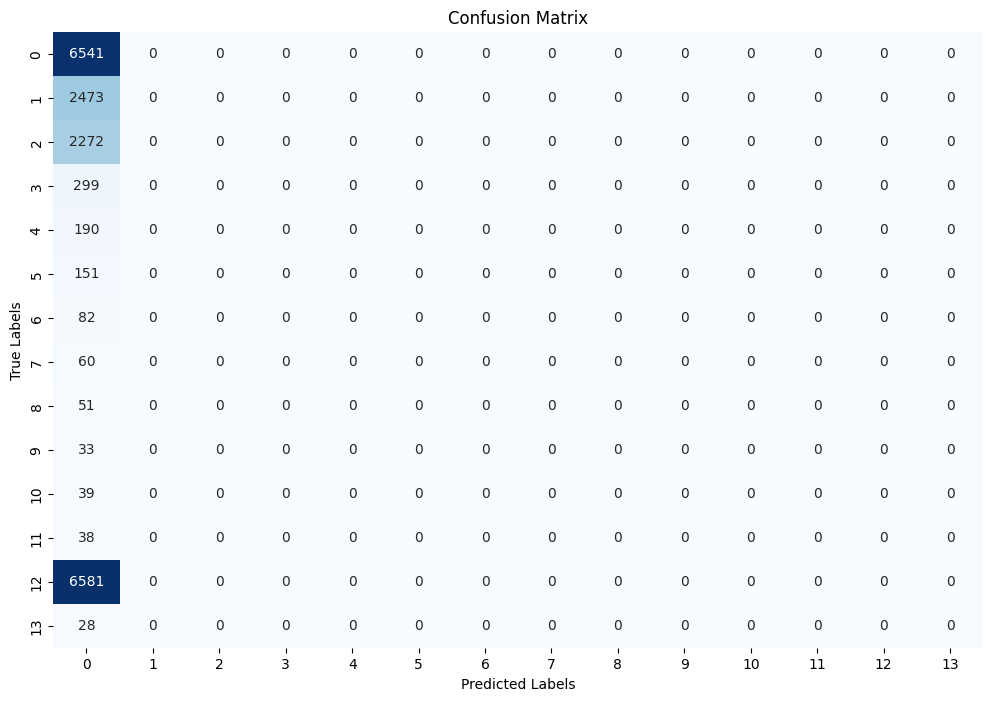

In [ ]:
# Assuming you have obtained predictions
y_pred2 = keras_model.predict(X_test2)
import numpy as np

# Convert one-hot encoded predictions and true labels to class labels
y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_true_classes2 = np.argmax(y_test_categorical2, axis=1)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_true_classes2, y_pred_classes2)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import shap
# Explain the model predictions using Kernel SHAP
explainer = shap.KernelExplainer(keras_model.predict, shap.sample(X_train2, 100))

4/4 [==============================] - 0s 3ms/step


In [ ]:
shap_values = explainer.shap_values(shap.sample(X_train2, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

6544/6544 [==============================] - 13s 2ms/step


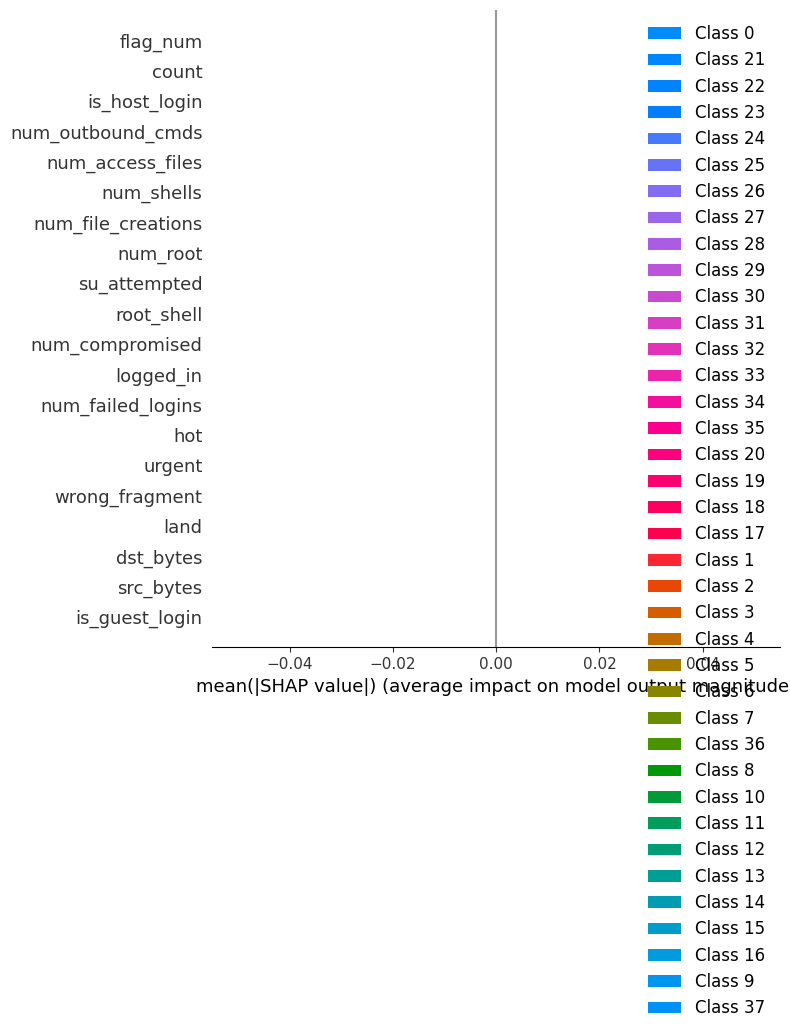

In [ ]:
# Summarize the feature importance
shap.summary_plot(shap_values, X_train2, feature_names=X_train2.columns)